# Task 2: Recommendation Engine - K Nearest Recommendation in similar location


## Setting up the Notebook

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import linkage,dendrogram,cut_tree
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pathlib import Path

## Load the Preprocessed Train Data

In [ ]:
df_train = pd.read_csv("../clean_data/train_preproc.csv", index_col=0)
df_train

In [ ]:
df_test = pd.read_csv("../clean_data/test_preproc.csv", index_col=0)
df_test

## Computing the Top Recommendations

## Methodology

- We first want to use the location as a filter to
prepare input data for recommendations. We acheived this using KMeans clustering with cluster size = 30 on lat-long 
feature.

- For a particular listing that a user viewed, we looked into which nearest lat-long cluster it belongs to.

- We filtered the house listings from this cluster and applied kNN to estimate the house listing that the user would
like to view on based on features like size per room, number of beds, house size in sqft and number of shopping malls. 

- The neighbour listings of the user house viewing are identified using the Euclidean distance between these features. 

- We then use the k neighbour outcomes from the house listing to show the recommendations to the user.

In [ ]:
df_train_simple=df_train[['lat','lng']]

In [ ]:
def kmeans_model(data, nclusters):
    X = data.copy()
    cols = list(X.columns)
    km = KMeans(n_clusters=nclusters, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    return km


def get_clusters(km, data, nclusters):
    X = data.copy()
    cols = list(X.columns)
    y_km = km.fit_predict(X)
    X['cluster']=y_km
    return X

def cluster_plot(km, data, nclusters):
    X = data.copy()
    cols = list(X.columns)
    y_km = km.fit_predict(X)
    
    # Visualize it:
    plt.figure(figsize=(12, 10))
    plt.scatter(X.iloc[:,0], X.iloc[:,1], c=km.labels_.astype(float))

    # plot the centroids
    plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=250, marker='*', c='red', label='centroids')
    plt.xlabel(cols[0])
    plt.ylabel(cols[1])
    plt.legend(scatterpoints=1)
    plt.grid()
    plt.show()

In [ ]:
km = kmeans_model(df_train_simple,30)
cluster_plot(km, df_train_simple, 30)

In [ ]:
new_clustered_data = get_clusters(km, df_train_simple, 30)
new_clustered_data

In [8]:

score = []
for k in range(2,30):
    kmeans = KMeans(n_clusters=k,random_state=4)
    kmeans.fit(df_train_simple)
    labels = kmeans.labels_
    ss = silhouette_score(df_train_simple,labels)
    score.append(ss)

Text(0.5, 0, 'no of clusters')

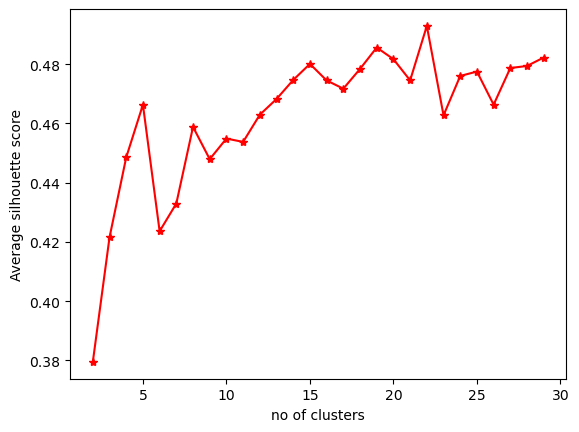

In [9]:
plt.plot(range(2,30), score, marker='*',color='r')
plt.ylabel('Average silhouette score')
plt.xlabel('no of clusters')

### new_clustered_data contains the filtered data based on lat-long cluster

In [10]:
def get_filtered_location_for_input_viewing(test_data, km, df_train):
    row_location = test_data[["lat", "lng"]]
    y_km = km.predict(row_location)
    one_clustered_data = df_train[new_clustered_data["cluster"] == y_km[0]]
    return one_clustered_data
    #y_km

## Main class to train the kNN Model and find recommendations.

In [11]:
from sklearn.neighbors import NearestNeighbors

class Recommender:
    def __init__(self, X, k=10):
        self.X = X


    def feature_selection(self, feature_list):
        return self.X[feature_list]


    def train_model(self, model_input):
        nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(model_input)
        return nbrs
    
    def predict_k(self, nbrs, predict_input_data):
        distances, indices = nbrs.kneighbors(predict_input_data)
        return indices


    def find_house_recommendations(self, recommendations, visited_house_history, num_of_recom = k):
        filtered_houses = recommendations.iloc[visited_house_history]
        return filtered_houses

In [15]:
def get_top_recommendations(row, **kwargs) -> pd.DataFrame:
    k = None
    
    for key, value in kwargs.items():
        if key == 'k':
            k = value
        if key == 'train_input':
           train_input = value
        if key == 'model':
           location_model = value
            
    # print(len(train_input))

    #Get all data points of same location cluster
    
    recommendations_input = get_filtered_location_for_input_viewing(row, location_model, train_input)

    #Call K nearest neighbour on this filtered cluster

    obj = Recommender(recommendations_input)
    model_input = obj.feature_selection(['size_per_room','num_baths','num_beds','size_sqft'])
    k_model = obj.train_model(model_input)
    predict_input_data = row[['size_per_room','num_baths','num_beds','size_sqft']]
    recommendations_out = obj.predict_k(k_model, predict_input_data)
    # print(recommendations_out)


    recommen_input_data = recommendations_input.copy()
    recommen_input_data1 = recommen_input_data.reset_index()
    out_idx = recommendations_out[0].tolist()
    
    # return Top k neighbours of the test data
    df_result = obj.find_house_recommendations(recommen_input_data1, out_idx, num_of_recom = k)
    # print(df_result.shape)

    return df_result


## Testing the Recommendation Engine(recommendations made)

- Let's say the user views one of the listing. We shall use his information to suggest recommendations.
- For a particular listing that a user viewed, we looked into which nearest lat-long cluster it belongs to.

In [13]:
# Pick a row id of choice
#row_id = 10
row_id = 20
#row_id = 30
#row_id = 40
#row_id = 50

# Get the row from the dataframe (an valid row ids will throw an error)
row_location = df_test.iloc[row_id][["lat", "lng"]]
row = df_test.iloc[row_id]
test_data = pd.DataFrame([row])
test_data

,property_type,built_year,num_beds,num_baths,size_sqft,total_num_units,lat,lng,subzone,planning_area,...,mean_property_sqft,mean_planning_sqft,planning_area_mean,total_rooms,size_per_room,mean_property_type,distance,num_shopping_malls,tenure_99-year leasehold,tenure_freehold
20,executive condo,2027.0,4.0,4.0,1335,616.0,1.434928,103.845282,yishun east,yishun,...,1157.798811,1231.474343,1.143726e+06,8.0,166.875,1.466825e+06,1.294509,2.0,1,0


## Compute and Display the recommendations

Here K = 10. So it wil display top 10 recommendations for a given input

In [16]:
k = 10

df_recommendations = get_top_recommendations(test_data, k=k, train_input=df_train, model=km)
df_recommendations

,index,property_type,built_year,num_beds,num_baths,size_sqft,total_num_units,lat,lng,subzone,...,mean_property_sqft,mean_planning_sqft,planning_area_mean,total_rooms,size_per_room,mean_property_type,distance,num_shopping_malls,tenure_99-year leasehold,tenure_freehold
221,5837,executive condo,2027,4.0,4.0,1335,616,1.434928,103.845282,yishun east,...,1157.798811,1231.474343,1.143726e+06,8.0,166.875000,1.466825e+06,1.294509,2.0,1,0
553,14672,executive condo,2027,4.0,4.0,1335,616,1.434928,103.845282,yishun east,...,1157.798811,1231.474343,1.143726e+06,8.0,166.875000,1.466825e+06,1.294509,2.0,1,0
368,9439,executive condo,2027,4.0,4.0,1335,616,1.434928,103.845282,yishun east,...,1157.798811,1231.474343,1.143726e+06,8.0,166.875000,1.466825e+06,1.294509,2.0,1,0
205,5484,executive condo,2027,4.0,4.0,1313,616,1.434928,103.845282,yishun east,...,1157.798811,1231.474343,1.143726e+06,8.0,164.125000,1.466825e+06,1.294509,2.0,1,0
186,4829,executive condo,2027,4.0,4.0,1313,616,1.434928,103.845282,yishun east,...,1157.798811,1231.474343,1.143726e+06,8.0,164.125000,1.466825e+06,1.294509,2.0,1,0
448,11668,executive condo,2027,4.0,4.0,1313,616,1.434928,103.845282,yishun east,...,1157.798811,1231.474343,1.143726e+06,8.0,164.125000,1.466825e+06,1.294509,2.0,1,0
265,6924,executive condo,2027,4.0,4.0,1313,616,1.434218,103.844532,yishun east,...,1157.798811,1231.474343,1.143726e+06,8.0,164.125000,1.466825e+06,1.184451,2.0,1,0
652,17663,executive condo,2027,4.0,3.0,1313,616,1.434928,103.845282,yishun east,...,1157.798811,1231.474343,1.143726e+06,7.0,187.571429,1.466825e+06,1.294509,2.0,1,0
121,3022,executive condo,2027,4.0,3.0,1313,616,1.434928,103.845282,yishun east,...,1157.798811,1231.474343,1.143726e+06,7.0,187.571429,1.466825e+06,1.294509,2.0,1,0
730,19769,executive condo,2027,4.0,3.0,1313,616,1.434928,103.845282,yishun east,...,1157.798811,1231.474343,1.143726e+06,7.0,187.571429,1.466825e+06,1.294509,2.0,1,0
